## Importing all the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2

Using TensorFlow backend.


In [2]:
np.random.seed(0)

## Loading the data as train, test & valadition.

In [3]:
datasets_path = "F:/Desktop/tsr2/DataSet/german-traffic-signs/"
models_path = "./models/"

training_file = datasets_path + 'train.p'
validation_file= datasets_path + 'valid.p'
testing_file = datasets_path + 'test.p'

with open(training_file, mode='rb') as f:
    train_data = pickle.load(f)
with open(validation_file, mode='rb') as f:
    val_data = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test_data = pickle.load(f)
    
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

# Step-: Dataset Summary & Exploration
The pickled data is a dictionary with 4 key/value pairs:

* 'features' is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
* 'labels' is a 1D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id.
* 'sizes' is a list containing tuples, (width, height) representing the original width and height the image.
* 'coords' is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.
#### THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES

In [4]:
# Let's get some dimensions
print("Features shape X_train: ", X_train.shape)
print("Features shape y_train: ", y_train.shape)

Features shape X_train:  (34799, 32, 32, 3)
Features shape y_train:  (34799,)


In [5]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [6]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_val.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


#### This step is just to make sure that I can come to know about any errors easily. One can skip this step if wanted

In [7]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

### Utility functions

In [8]:
########################################################################################################################
######                                        Data manipulation functions                                         ######
########################################################################################################################

def group_img_id_to_lbl(lbl_ids, lbl_names):    
    """
    Utility function to group images by label 
    """
    arr_map = []
    for i in range(0, lbl_ids.shape[0]):
        label_id = lbl_ids[i]
        label_name = lbl_names[lbl_names["ClassId"] == label_id]["SignName"].values[0]
        arr_map.append({"img_id": i, "label_id": label_id, "label_name": label_name, "label_count": 'null'})
#         arr_map.append({"label_id": label_id, "label_name": label_name, "label_count": 'null'})

    return pd.DataFrame(arr_map)

def group_img_id_to_lbl_count(img_id_to_lbl):
    """
    Returns a pivot table table indexed by label id and label name, where the aggregate function is count
    """
    return pd.pivot_table(img_id_to_lbl, index=["label_id", "label_name"], values=["label_count"], aggfunc='count')

def create_sample_set(grouped_imgs_by_label, imgs, labels, pct=0.4):
    """
    Creates a sample set containing pct elements of the original grouped dataset
    """
    X_sample = []
    y_sample = []

    for (lid, lbl), group in grouped_imgs_by_label:
        group_size = group['img_id'].size
        img_count_to_copy = int(group_size * pct)
        rand_idx = np.random.randint(0, high=group_size, size=img_count_to_copy, dtype='int')

        selected_img_ids = group.iloc[rand_idx]['img_id'].values
        selected_imgs = imgs[selected_img_ids]
        selected_labels = labels[selected_img_ids]
        X_sample = selected_imgs if len(X_sample) == 0 else np.concatenate((selected_imgs, X_sample), axis=0)
        y_sample = selected_labels if len(y_sample) == 0 else np.concatenate((selected_labels, y_sample), axis=0)


    return (X_sample, y_sample)

In [11]:
########################################################################################################################
######                                        Plot utility functions                                              ######
########################################################################################################################

def show_random_images_from_dataset(x_dataset, y_dataset, sign_data=sign_name_data, cols=6,num_classes= 43):
     
#     num_of_samples =[]
    fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(15,80))
    # fig.tight_layout()

    for i in range(cols):
        for j, row in sign_data.iterrows():
          x_selected = x_dataset[y_dataset == j]
          axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
          axs[j][i].axis("off")
          if i == 2:
            axs[j][i].set_title("\n" + str(j) + " - " + row["SignName"], fontsize=12, fontweight='bold')
    #         num_of_samples.append(len(x_selected))

    # fig.suptitle(t=None, fontsize=12, fontweight='bold', y = 0.6)
    fig.tight_layout()
    plt.show()

## Visualising the data

### Group Images In Training set

In [10]:
sign_name_data = pd.read_csv('F:/Desktop/tsr2/DataSet/german-traffic-signs/signnames.csv')

In [12]:
sign_name_data.head(n=10)

ClassId                     SignName
0        0         Speed limit (20km/h)
1        1         Speed limit (30km/h)
2        2         Speed limit (50km/h)
3        3         Speed limit (60km/h)
4        4         Speed limit (70km/h)
5        5         Speed limit (80km/h)
6        6  End of speed limit (80km/h)
7        7        Speed limit (100km/h)
8        8        Speed limit (120km/h)
9        9                   No passing

In [13]:
# pd.DataFrame(train_data['features']).head()

In [14]:
pd.DataFrame(y_train).head()

0
0  41
1  41
2  41
3  41
4  41

In [15]:
X_train_id_to_label = group_img_id_to_lbl(y_train, sign_name_data)

In [16]:
# Let's print a few of those mappings now
X_train_id_to_label.head()

img_id  label_id         label_name label_count
0       0        41  End of no passing        null
1       1        41  End of no passing        null
2       2        41  End of no passing        null
3       3        41  End of no passing        null
4       4        41  End of no passing        null

In [17]:
# We should group by label id to understand the distribution
X_train_group_by_label_count = group_img_id_to_lbl_count(X_train_id_to_label)

In [18]:
X_train_group_by_label_count.head(7)

label_count
label_id label_name                              
0        Speed limit (20km/h)                 180
1        Speed limit (30km/h)                1980
2        Speed limit (50km/h)                2010
3        Speed limit (60km/h)                1260
4        Speed limit (70km/h)                1770
5        Speed limit (80km/h)                1650
6        End of speed limit (80km/h)          360

In [19]:
X_train_group_by_label_count.tail(10)

label_count
label_id label_name                                                     
33       Turn right ahead                                            599
34       Turn left ahead                                             360
35       Ahead only                                                 1080
36       Go straight or right                                        330
37       Go straight or left                                         180
38       Keep right                                                 1860
39       Keep left                                                   270
40       Roundabout mandatory                                        300
41       End of no passing                                           210
42       End of no passing by vechiles over 3.5 metric tons          210

We can already witness siginificant data imbalance across the classes in the training. For instance class 0 has less than 200 images, while class 2 has over 2000 images. Let's plot the number of images against the class to better understand visually where we stand.
### Training Set Distribution Visualization

In [20]:
no_of_samples_per_class=[]

for i, row in sign_name_data.iterrows():
    class_i_data = X_train[y_train == i]
    no_of_samples_per_class.append(len(class_i_data))
print(no_of_samples_per_class)

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


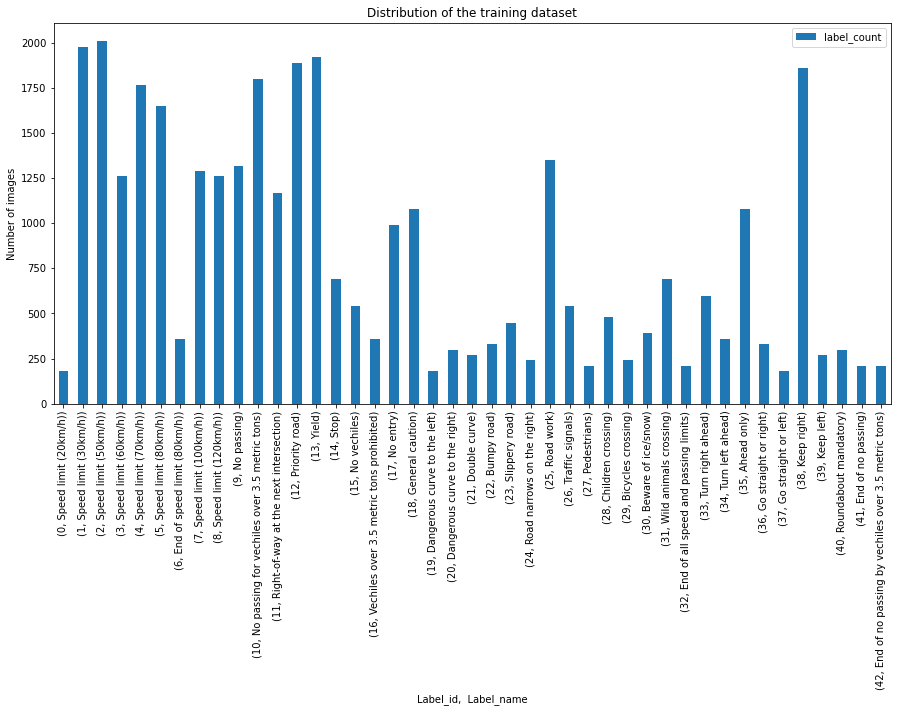

In [21]:
# Now count the number of images for each class and plot the results so that we understand the distribution
print(no_of_samples_per_class)
X_train_group_by_label_count.plot(kind='bar', figsize=(15, 7))
plt.title("Distribution of the training dataset")
plt.xlabel("Label_id,  Label_name")
plt.ylabel("Number of images")
plt.show()

## Training Set Image Visualization

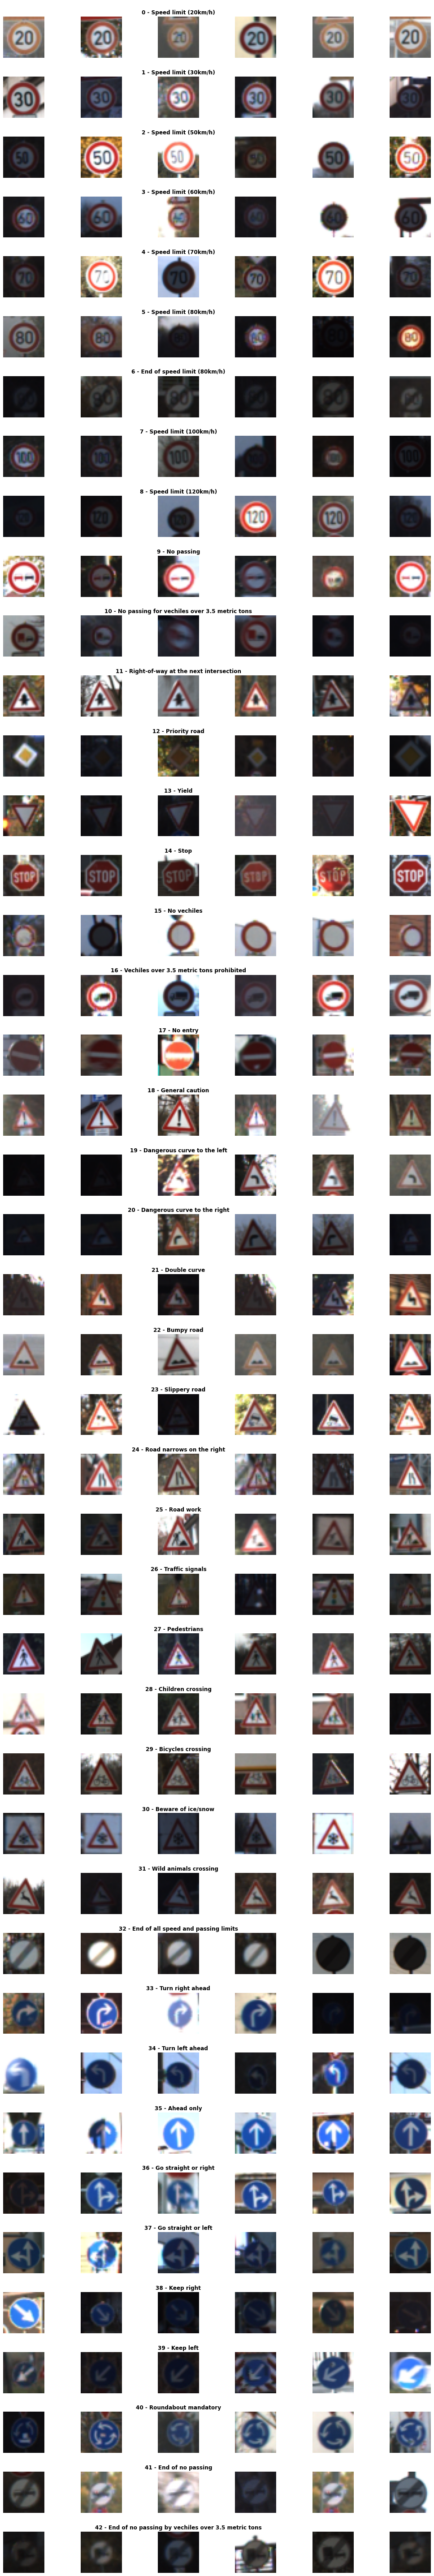

In [22]:
show_random_images_from_dataset(X_train, y_train)

#### Using OpenCV2 for preprocessing the image.

(32, 32, 3)
36


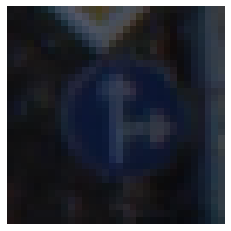

In [23]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

In [24]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

(32, 32)


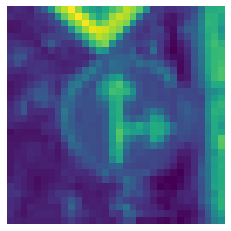

In [25]:
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


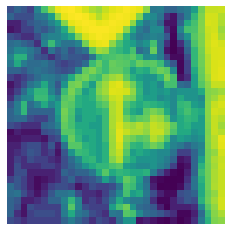

In [26]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [27]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

(34799, 32, 32)


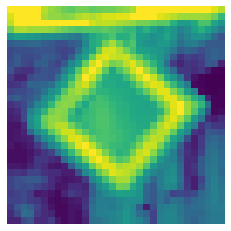

In [28]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))
 
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [29]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

### Applying the preprocessing function to every image in dataset

(15, 32, 32, 1)


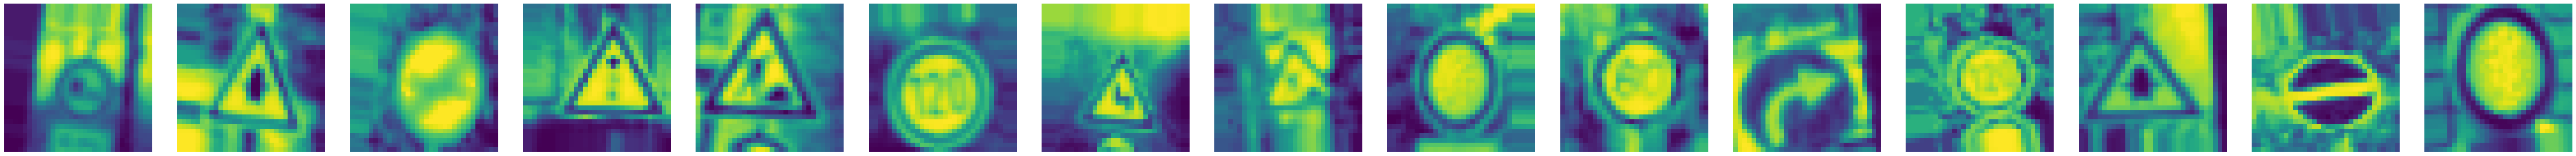

In [30]:
from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 
datagen.fit(X_train)
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(60, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
 
print(X_batch.shape)

In [31]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

#### Defining the CNN model. I have taken inspiration from the traditional LeNet architecture as I am curious how this old model performs on such a huge dataset

In [32]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [33]:
model = modified_model()
print(model.summary())
 
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                            epochs=10,
                            validation_data=(X_val, y_val), shuffle = 1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)              

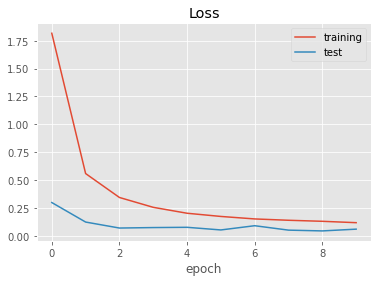

In [69]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','test'])
plt.title('Loss')
plt.xlabel('epoch')
plt.style.use('ggplot')

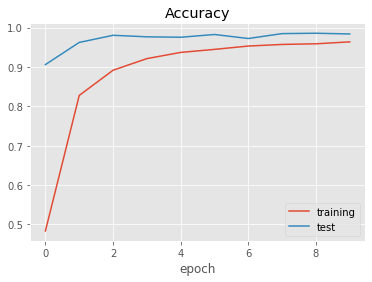

In [70]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.style.use('ggplot')

## Taking a random image from Internet to test my model
### Method-1 (from a folder) Using "os + cv2"

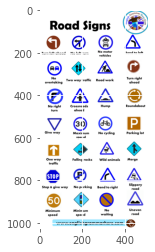

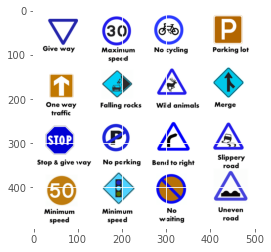

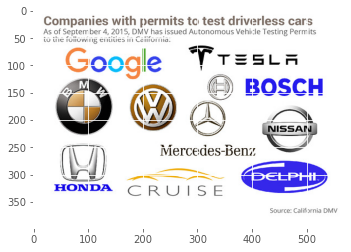

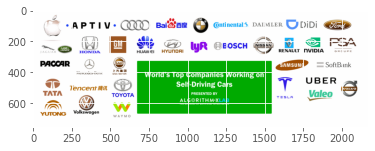

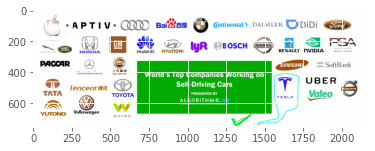

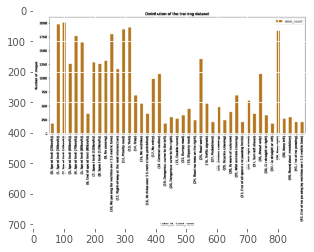

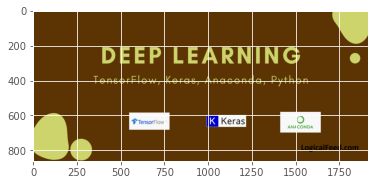

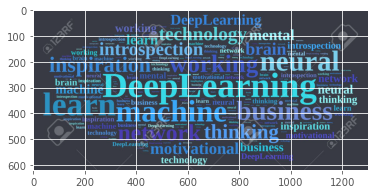

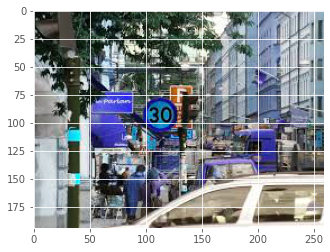

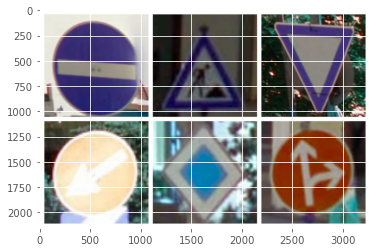

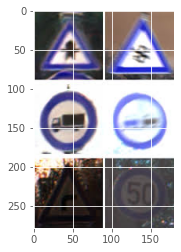

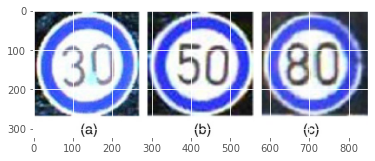

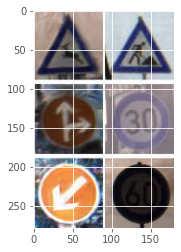

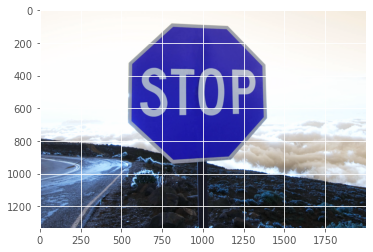

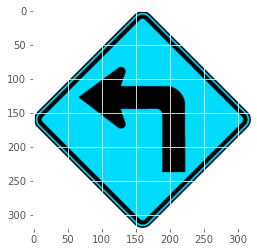

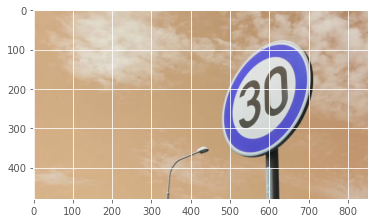

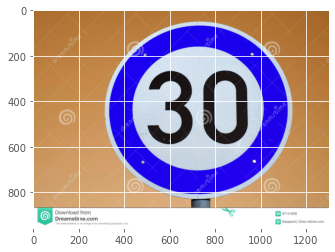

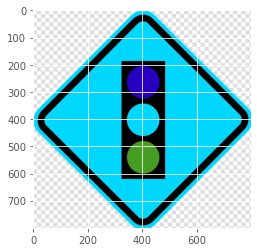

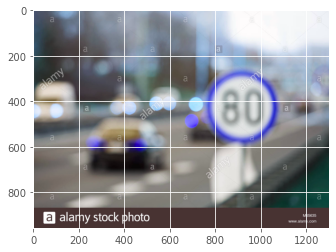

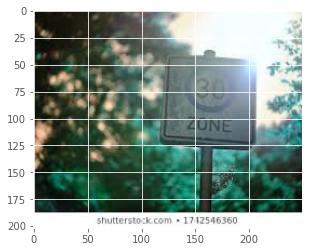

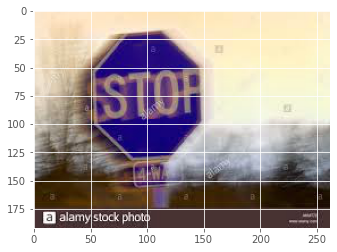

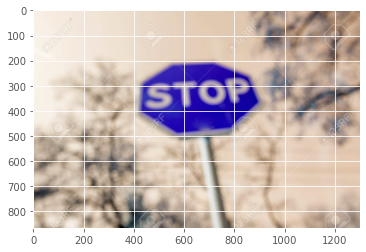

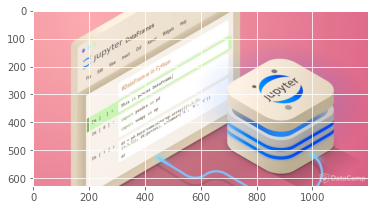

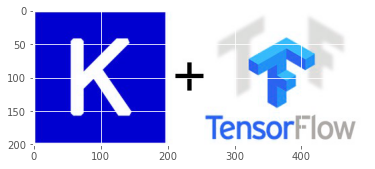

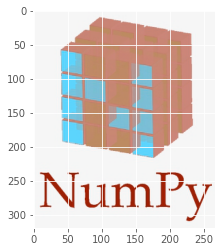

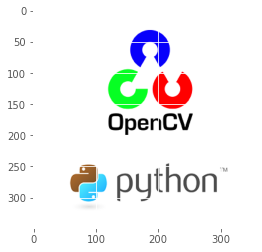

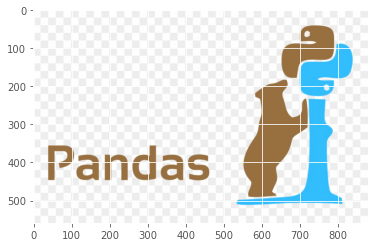

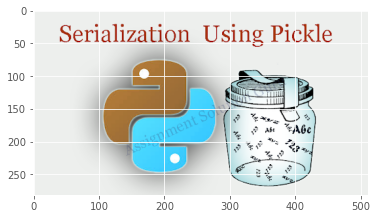

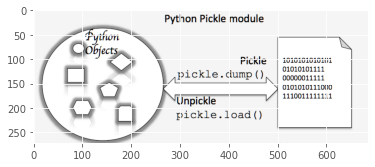

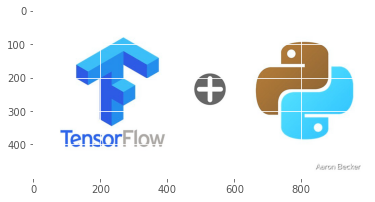

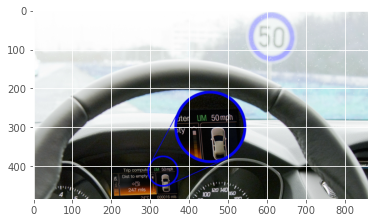

In [71]:
import os
import cv2

folder="F:/Desktop/tsr2/google-images"
images = []
for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder,filename))
    if img is not None:
        images.append(img)
        plt.imshow(img, cmap=plt.get_cmap('gray'))
        plt.show()

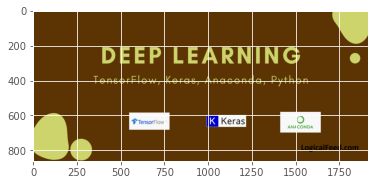

In [72]:
plt.imshow(images[6])
plt.show()

### Method-2 (from a folder) Using "glob + PIL"

F:/Desktop/tsr2\google-images\companies.jpg


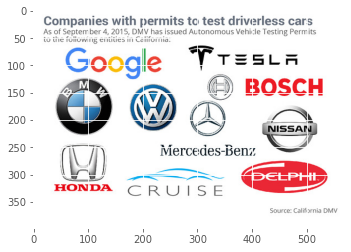

F:/Desktop/tsr2\google-images\companies2.jpg


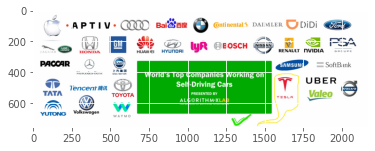

F:/Desktop/tsr2\google-images\Deepl_img.jpg


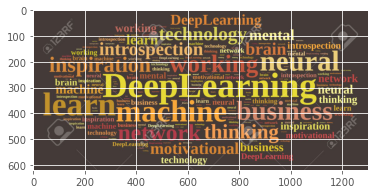

F:/Desktop/tsr2\google-images\images11.jpg


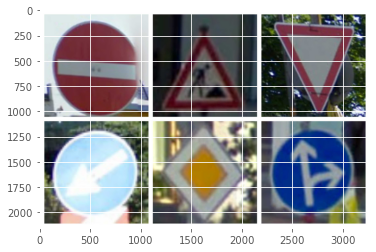

F:/Desktop/tsr2\google-images\img0.jpg


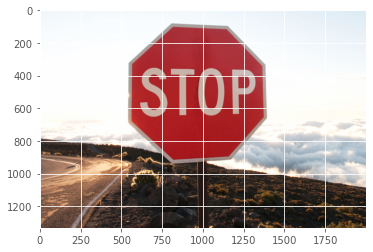

F:/Desktop/tsr2\google-images\img2.jpg


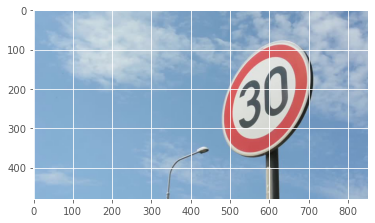

F:/Desktop/tsr2\google-images\img3.jpg


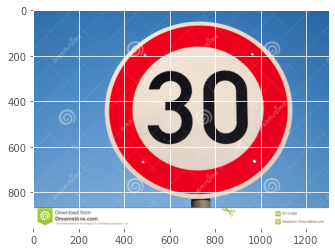

F:/Desktop/tsr2\google-images\img4.jpg


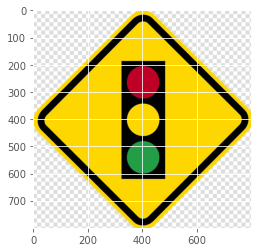

F:/Desktop/tsr2\google-images\img5.jpg


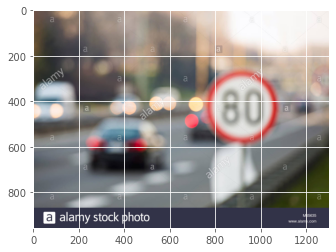

F:/Desktop/tsr2\google-images\img9.jpg


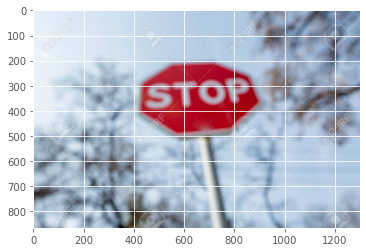

F:/Desktop/tsr2\google-images\tensorflow-img.jpg


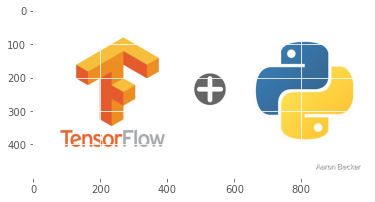

F:/Desktop/tsr2\google-images\TSR-img.jpg


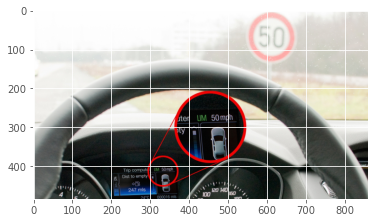

In [73]:
import glob
from PIL import Image

root_dir = "F:/Desktop/tsr2/google-images"
for file in glob.iglob(root_dir + '**/*.jpg', recursive=True):
    print(file)
    img = Image.open(file)
    plt.imshow(img)
    plt.show()

### Method-3 (from Internet) Using "requests + PIL"

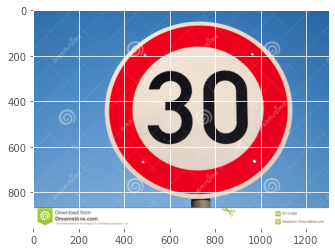

In [77]:
import requests
from PIL import Image

# url = "https://thumbs.dreamstime.com/t/road-signs-main-road-sign-blue-background-road-signs-main-road-sign-blue-background-109436823.jpg"
url="https://harikesh-bucket-1.s3.ap-south-1.amazonaws.com/img3.jpg"
# url="https://harikesh-bucket-1.s3.ap-south-1.amazonaws.com/img2.jpg"
# url="https://harikesh-bucket-1.s3.ap-south-1.amazonaws.com/img4.jpg"
# url="https://harikesh-bucket-1.s3.ap-south-1.amazonaws.com/img1.png"

r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show()

(32, 32)


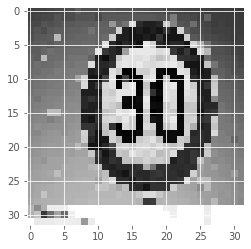

In [78]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

#### As seen below that the model is accuretly able to classify a random google image. This image belongs to the category 12, one can scroll up and find it in the data visualization part of this notebook

In [79]:
print("predicted sign: "+ str(model.predict_classes(img)))
# the prediction is correct.

predicted sign: [1]


#### I used the traditional LeNet model architecture for classifing road symbols. The model seems to work very well as I achieved validation accuracy of around 99% which is really amazing. Also I tried certain random images from the Internet to classify, the model was accuretly able to classify them. I added only a single dropout layer which produced a very good accuracy. The best part of the model is that it has generalize the data very well.